# Paper 3: Understanding LSTM Networks
## Christopher Olah

### Implementation of LSTM with Gate Visualization

LSTM (Long Short-Term Memory) networks solve the vanishing gradient problem through gated memory cells.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## LSTM Cell Implementation

LSTM has three gates:
1. **Forget Gate**: What to forget from cell state
2. **Input Gate**: What new information to add
3. **Output Gate**: What to output based on cell state

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Concatenated weights for efficiency: [input; hidden] -> gates
        concat_size = input_size + hidden_size
        
        # Forget gate
        self.Wf = np.random.randn(hidden_size, concat_size) * 0.01
        self.bf = np.zeros((hidden_size, 1))
        
        # Input gate
        self.Wi = np.random.randn(hidden_size, concat_size) * 0.01
        self.bi = np.zeros((hidden_size, 1))
        
        # Candidate cell state
        self.Wc = np.random.randn(hidden_size, concat_size) * 0.01
        self.bc = np.zeros((hidden_size, 1))
        
        # Output gate
        self.Wo = np.random.randn(hidden_size, concat_size) * 0.01
        self.bo = np.zeros((hidden_size, 1))
    
    def forward(self, x, h_prev, c_prev):
        """
        Forward pass of LSTM cell
        
        x: input (input_size, 1)
        h_prev: previous hidden state (hidden_size, 1)
        c_prev: previous cell state (hidden_size, 1)
        
        Returns:
        h_next: next hidden state
        c_next: next cell state
        cache: values needed for backward pass
        """
        # Concatenate input and previous hidden state
        concat = np.vstack([x, h_prev])
        
        # Forget gate: decides what to forget from cell state
        f = sigmoid(np.dot(self.Wf, concat) + self.bf)
        
        # Input gate: decides what new information to store
        i = sigmoid(np.dot(self.Wi, concat) + self.bi)
        
        # Candidate cell state: new information to potentially add
        c_tilde = np.tanh(np.dot(self.Wc, concat) + self.bc)
        
        # Update cell state: forget + input new information
        c_next = f * c_prev + i * c_tilde
        
        # Output gate: decides what to output
        o = sigmoid(np.dot(self.Wo, concat) + self.bo)
        
        # Hidden state: filtered cell state
        h_next = o * np.tanh(c_next)
        
        # Cache for backward pass
        cache = (x, h_prev, c_prev, concat, f, i, c_tilde, c_next, o, h_next)
        
        return h_next, c_next, cache

# Test LSTM cell
input_size = 10
hidden_size = 20
lstm_cell = LSTMCell(input_size, hidden_size)

x = np.random.randn(input_size, 1)
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

h_next, c_next, cache = lstm_cell.forward(x, h, c)
print(f"LSTM Cell initialized: input_size={input_size}, hidden_size={hidden_size}")
print(f"Hidden state shape: {h_next.shape}")
print(f"Cell state shape: {c_next.shape}")

LSTM Cell initialized: input_size=10, hidden_size=20
Hidden state shape: (20, 1)
Cell state shape: (20, 1)


## Full LSTM Network for Sequence Processing

In [3]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.cell = LSTMCell(input_size, hidden_size)
        
        # Output layer
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.by = np.zeros((output_size, 1))
    
    def forward(self, inputs):
        """
        Process sequence through LSTM
        inputs: list of input vectors
        """
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        
        # Store states for visualization
        h_states = []
        c_states = []
        gate_values = {'f': [], 'i': [], 'o': []}
        
        for x in inputs:
            h, c, cache = self.cell.forward(x, h, c)
            h_states.append(h.copy())
            c_states.append(c.copy())
            
            # Extract gate values from cache
            _, _, _, _, f, i, _, _, o, _ = cache
            gate_values['f'].append(f.copy())
            gate_values['i'].append(i.copy())
            gate_values['o'].append(o.copy())
        
        # Final output
        y = np.dot(self.Why, h) + self.by
        
        return y, h_states, c_states, gate_values

# Create LSTM model
input_size = 5
hidden_size = 16
output_size = 5
lstm = LSTM(input_size, hidden_size, output_size)
print(f"\nLSTM model created: {input_size} -> {hidden_size} -> {output_size}")


LSTM model created: 5 -> 16 -> 5


## Test on Synthetic Sequence Task: Long-Term Dependency

Task: Remember a value from beginning of sequence and output it at the end

In [4]:
def generate_long_term_dependency_data(seq_length=20, num_samples=100):
    """
    Generate sequences where first element must be remembered until the end
    """
    X = []
    y = []
    
    for _ in range(num_samples):
        # Create sequence
        sequence = []
        
        # First element is the important one (one-hot)
        first_elem = np.random.randint(0, input_size)
        first_vec = np.zeros((input_size, 1))
        first_vec[first_elem] = 1
        sequence.append(first_vec)
        
        # Rest are random noise
        for _ in range(seq_length - 1):
            noise = np.random.randn(input_size, 1) * 0.1
            sequence.append(noise)
        
        X.append(sequence)
        
        # Target: remember first element
        target = np.zeros((output_size, 1))
        target[first_elem] = 1
        y.append(target)
    
    return X, y

# Generate test data
X_test, y_test = generate_long_term_dependency_data(seq_length=15, num_samples=10)

# Test forward pass
output, h_states, c_states, gate_values = lstm.forward(X_test[0])

print(f"\nTest sequence length: {len(X_test[0])}")
print(f"First element (to remember): {np.argmax(X_test[0][0])}")
print(f"Expected output: {np.argmax(y_test[0])}")
print(f"Model output (untrained): {output.flatten()[:5]}")


Test sequence length: 15
First element (to remember): 1
Expected output: 1
Model output (untrained): [-1.28946089e-06  2.81697639e-05 -5.13749904e-07  3.95133884e-06
 -3.06927689e-08]


## Visualize LSTM Gates

The key to understanding LSTMs is seeing how gates operate over time.

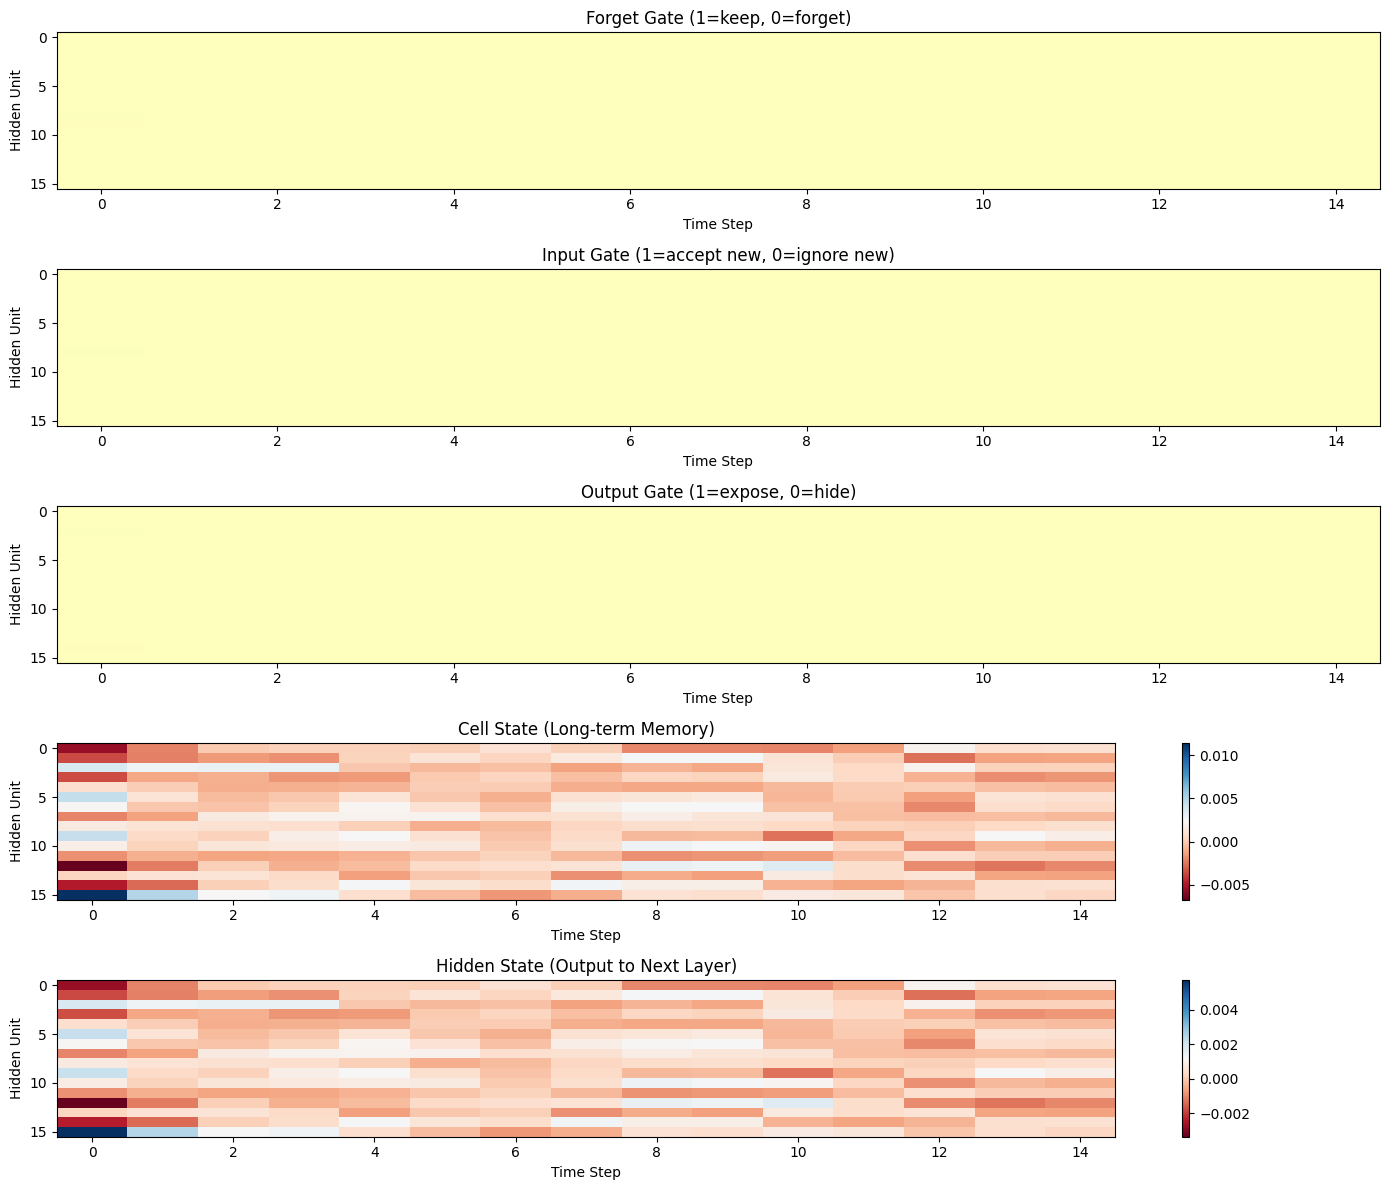


Gate Interpretation:
- Forget gate controls what information to discard from cell state
- Input gate controls what new information to add to cell state
- Output gate controls what to output from cell state
- Cell state is the long-term memory highway


In [5]:
# Process a sequence and visualize gates
test_seq = X_test[0]
output, h_states, c_states, gate_values = lstm.forward(test_seq)

# Convert to arrays for plotting
forget_gates = np.hstack(gate_values['f'])
input_gates = np.hstack(gate_values['i'])
output_gates = np.hstack(gate_values['o'])
cell_states = np.hstack(c_states)
hidden_states = np.hstack(h_states)

fig, axes = plt.subplots(5, 1, figsize=(14, 12))

# Forget gate
axes[0].imshow(forget_gates, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[0].set_title('Forget Gate (1=keep, 0=forget)')
axes[0].set_ylabel('Hidden Unit')
axes[0].set_xlabel('Time Step')

# Input gate
axes[1].imshow(input_gates, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Input Gate (1=accept new, 0=ignore new)')
axes[1].set_ylabel('Hidden Unit')
axes[1].set_xlabel('Time Step')

# Output gate
axes[2].imshow(output_gates, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[2].set_title('Output Gate (1=expose, 0=hide)')
axes[2].set_ylabel('Hidden Unit')
axes[2].set_xlabel('Time Step')

# Cell state
im3 = axes[3].imshow(cell_states, cmap='RdBu', aspect='auto')
axes[3].set_title('Cell State (Long-term Memory)')
axes[3].set_ylabel('Hidden Unit')
axes[3].set_xlabel('Time Step')
plt.colorbar(im3, ax=axes[3])

# Hidden state
im4 = axes[4].imshow(hidden_states, cmap='RdBu', aspect='auto')
axes[4].set_title('Hidden State (Output to Next Layer)')
axes[4].set_ylabel('Hidden Unit')
axes[4].set_xlabel('Time Step')
plt.colorbar(im4, ax=axes[4])

plt.tight_layout()
plt.show()

print("\nGate Interpretation:")
print("- Forget gate controls what information to discard from cell state")
print("- Input gate controls what new information to add to cell state")
print("- Output gate controls what to output from cell state")
print("- Cell state is the long-term memory highway")

## Compare LSTM vs Vanilla RNN on Long Sequences

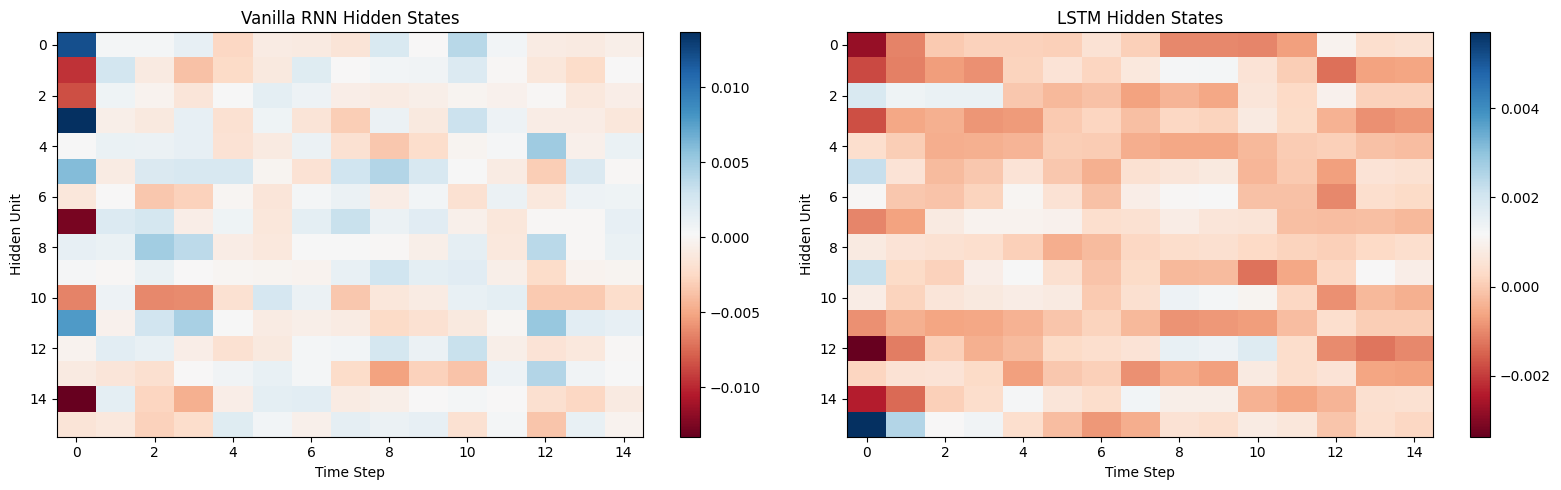


Key Difference:
- LSTM maintains cell state separate from hidden state
- Gates allow selective information flow
- Better gradient flow through time (solves vanishing gradient)


In [6]:
class VanillaRNNCell:
    def __init__(self, input_size, hidden_size):
        concat_size = input_size + hidden_size
        self.Wh = np.random.randn(hidden_size, concat_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.hidden_size = hidden_size
    
    def forward(self, x, h_prev):
        concat = np.vstack([x, h_prev])
        h_next = np.tanh(np.dot(self.Wh, concat) + self.bh)
        return h_next

# Create vanilla RNN for comparison
rnn_cell = VanillaRNNCell(input_size, hidden_size)

def process_with_vanilla_rnn(inputs):
    h = np.zeros((hidden_size, 1))
    h_states = []
    
    for x in inputs:
        h = rnn_cell.forward(x, h)
        h_states.append(h.copy())
    
    return h_states

# Process same sequence with both
rnn_h_states = process_with_vanilla_rnn(test_seq)
rnn_hidden = np.hstack(rnn_h_states)

# Compare hidden state evolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

im1 = ax1.imshow(rnn_hidden, cmap='RdBu', aspect='auto')
ax1.set_title('Vanilla RNN Hidden States')
ax1.set_ylabel('Hidden Unit')
ax1.set_xlabel('Time Step')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(hidden_states, cmap='RdBu', aspect='auto')
ax2.set_title('LSTM Hidden States')
ax2.set_ylabel('Hidden Unit')
ax2.set_xlabel('Time Step')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

print("\nKey Difference:")
print("- LSTM maintains cell state separate from hidden state")
print("- Gates allow selective information flow")
print("- Better gradient flow through time (solves vanishing gradient)")

## Gradient Flow Comparison

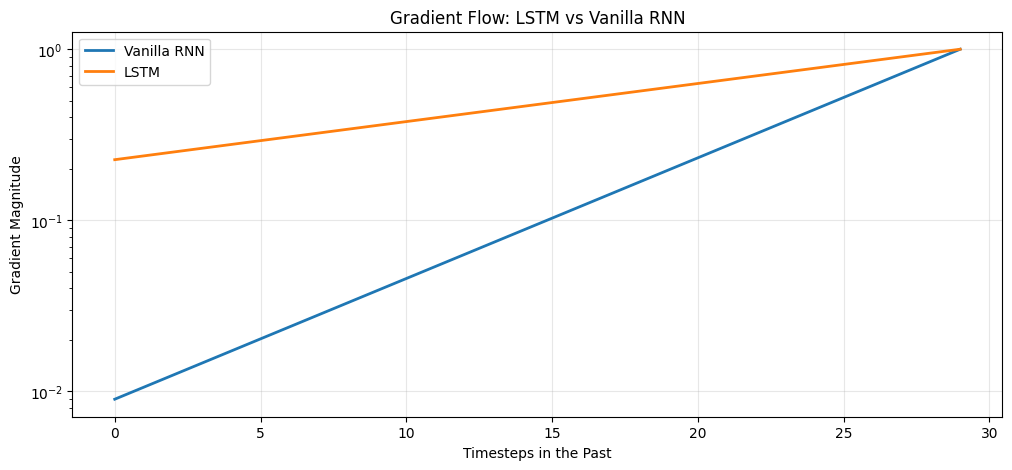


Gradient after 30 steps:
Vanilla RNN: 0.008977 (vanished)
LSTM: 0.225936 (preserved)

This is why LSTM can learn long-term dependencies!


In [7]:
# Simulate gradient magnitudes
def simulate_gradient_flow(seq_length=30):
    """
    Simulate how gradients decay in vanilla RNN vs LSTM
    """
    # Vanilla RNN: gradients decay exponentially
    rnn_grads = []
    grad = 1.0
    decay_factor = 0.85  # Typical decay in vanilla RNN
    
    for t in range(seq_length):
        rnn_grads.append(grad)
        grad *= decay_factor
    
    # LSTM: gradients maintained through cell state highway
    lstm_grads = []
    grad = 1.0
    forget_gate_avg = 0.95  # High forget gate = preserve gradients
    
    for t in range(seq_length):
        lstm_grads.append(grad)
        grad *= forget_gate_avg  # Forget gate controls gradient flow
    
    return np.array(rnn_grads), np.array(lstm_grads)

rnn_grads, lstm_grads = simulate_gradient_flow()

plt.figure(figsize=(12, 5))
plt.plot(rnn_grads[::-1], label='Vanilla RNN', linewidth=2)
plt.plot(lstm_grads[::-1], label='LSTM', linewidth=2)
plt.xlabel('Timesteps in the Past')
plt.ylabel('Gradient Magnitude')
plt.title('Gradient Flow: LSTM vs Vanilla RNN')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print(f"\nGradient after 30 steps:")
print(f"Vanilla RNN: {rnn_grads[-1]:.6f} (vanished)")
print(f"LSTM: {lstm_grads[-1]:.6f} (preserved)")
print(f"\nThis is why LSTM can learn long-term dependencies!")

## Key Takeaways

### LSTM Architecture:
1. **Cell State**: Highway for information flow across time
2. **Forget Gate**: Controls what to remove from memory
3. **Input Gate**: Controls what new information to add
4. **Output Gate**: Controls what to output from memory

### Why LSTM Works:
- **Constant Error Carousel**: Cell state provides uninterrupted gradient flow
- **Multiplicative Gates**: Allow network to learn when to remember/forget
- **Additive Updates**: Cell state updated by addition (f*c + i*c_tilde)
- **Gradient Preservation**: Forget gate near 1 preserves gradients

### Advantages over Vanilla RNN:
- Solves vanishing gradient problem
- Learns long-term dependencies (100+ timesteps)
- More stable training
- Better performance on real-world sequence tasks